## ref : https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 7]

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip
/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/new-york-city-taxi-with-osrm/test.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv
/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/train.csv
/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_train.csv
/kaggle/input/new-york-city-taxi-with-osrm/accidents_2016.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv


## Data understanding

In [2]:
train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip')
sample_submission = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip')

print('shape of train :', train.shape)
print('shape of test  :', test.shape)

display(train.head(2))
display(test.head(2))

shape of train : (1458644, 11)
shape of test  : (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


In [3]:
print('id is unique') if train['id'].nunique() == train.shape[0] else print('oops')
print('Train and Test sets are distinct') if np.intersect1d( train.id, test.id ).shape[0] == 0 else print('oops')
print('No missing values') if train.isna().sum().sum()==0 and test.isna().sum().sum()==0 else print('oops')
print()

print('Unique values of store_and_fwd_flag col :',
       set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))
print('Min Trip duration (in sec)  :', train.trip_duration.min())
print('Max Trip duration (in hour) :', train.trip_duration.max() // 3600)

id is unique
Train and Test sets are distinct
No missing values

Unique values of store_and_fwd_flag col : {'Y', 'N'}
Min Trip duration (in sec)  : 1
Max Trip duration (in hour) : 979


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Converting datatype & Adding new features

In [5]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

train['store_and_fwd_flag'] = (train['store_and_fwd_flag'] == 'Y') * 1
test['store_and_fwd_flag'] = (test['store_and_fwd_flag'] == 'Y') * 1

train['log_trip_duration'] = np.log1p(train.trip_duration)
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x : x.total_seconds())
print('Trip duration and datetimes are ok') if (np.abs(train['check_trip_duration'] - train['trip_duration']) > 1).sum() == 0 else print('oops')

Trip duration and datetimes are ok


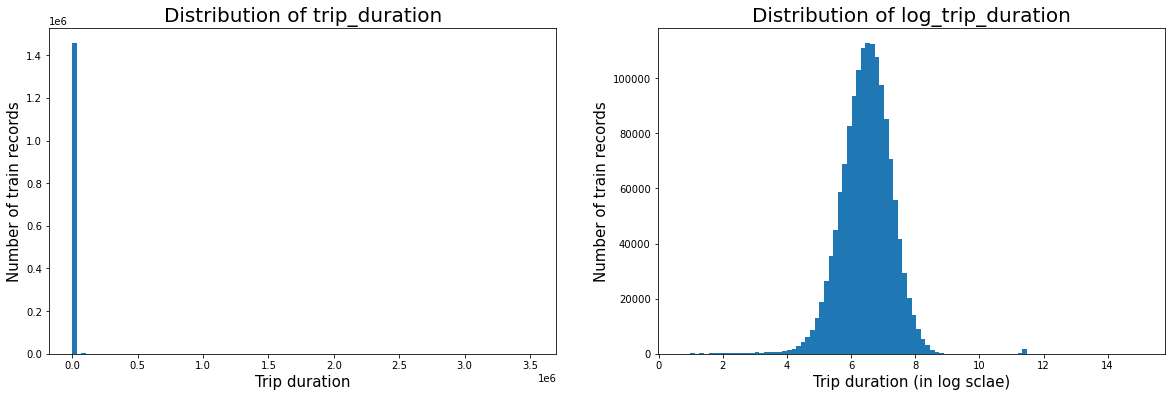

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].hist(train['trip_duration'], bins=100)
ax[0].set_title('Distribution of trip_duration', size=20)
ax[0].set_xlabel('Trip duration', size=15)
ax[0].set_ylabel('Number of train records', size=15)

ax[1].hist(train['log_trip_duration'], bins=100)
ax[1].set_title('Distribution of log_trip_duration', size=20)
ax[1].set_xlabel('Trip duration (in log sclae)', size=15)
ax[1].set_ylabel('Number of train records', size=15)
plt.show()